#Install


In [8]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install openmeteo-requests requests-cache retry-requests

In [2]:
!wget https://raw.githubusercontent.com/AnopanGT/InternCE/refs/heads/main/sales_pt_abc_2024.csv

--2025-09-14 08:46:45--  https://raw.githubusercontent.com/AnopanGT/InternCE/refs/heads/main/sales_pt_abc_2024.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8914 (8.7K) [text/plain]
Saving to: ‘sales_pt_abc_2024.csv’

sales_pt_abc_2024.c 100%[===================>]   8.71K  --.-KB/s    in 0.001s  

2025-09-14 08:46:45 (12.2 MB/s) - ‘sales_pt_abc_2024.csv’ saved [8914/8914]



#Import

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Extract daily weather data for Jakarta

In [9]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": -6.1818,
	"longitude": 106.8223,
	"start_date": "2024-01-01",
	"end_date": "2024-12-31",
	"daily": ["weather_code", "temperature_2m_mean", "temperature_2m_max", "apparent_temperature_mean", "apparent_temperature_max", "rain_sum", "precipitation_sum", "precipitation_hours", "sunshine_duration", "relative_humidity_2m_mean", "cloud_cover_mean"],
	"timezone": "Asia/Bangkok",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(2).ValuesAsNumpy()
daily_apparent_temperature_mean = daily.Variables(3).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
daily_rain_sum = daily.Variables(5).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(6).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(7).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(8).ValuesAsNumpy()
daily_relative_humidity_2m_mean = daily.Variables(9).ValuesAsNumpy()
daily_cloud_cover_mean = daily.Variables(10).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["weather_code"] = daily_weather_code
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["rain_sum"] = daily_rain_sum
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["precipitation_hours"] = daily_precipitation_hours
daily_data["sunshine_duration"] = daily_sunshine_duration
daily_data["relative_humidity_2m_mean"] = daily_relative_humidity_2m_mean
daily_data["cloud_cover_mean"] = daily_cloud_cover_mean

daily_dataframe = pd.DataFrame(data = daily_data)

nama_file_cuaca = 'cuaca_jakarta_2024.csv'
daily_dataframe.to_csv(nama_file_cuaca, index=False)
print(f"\n✅ Data cuaca berhasil disimpan ke file: {nama_file_cuaca}")

Coordinates: -6.151142120361328°N 106.84210205078125°E
Elevation: 15.0 m asl
Timezone: b'Asia/Bangkok'b'GMT+7'
Timezone difference to GMT+0: 25200s

✅ Data cuaca berhasil disimpan ke file: cuaca_jakarta_2024.csv


#Match the weather data with the sales data

In [14]:
# Nama file input dan output
file_cuaca = 'cuaca_jakarta_2024.csv'
file_penjualan = 'sales_pt_abc_2024.csv'
file_output = 'data_gabungan_penjualan_cuaca.csv'

try:
    # 1. Baca kedua file CSV
    df_cuaca = pd.read_csv(file_cuaca)
    df_penjualan = pd.read_csv(file_penjualan)
    print("✅ Berhasil membaca kedua file.")

    # 2. Membersihkan Data dan Menyamakan Tipe Data Tanggal
    print("\nMembersihkan dan memformat data...")

    # --- Proses Data Penjualan ---
    df_penjualan.columns = df_penjualan.columns.str.strip()
    df_penjualan['Sales'] = df_penjualan['Sales'].astype(str).str.replace(r'[ \"$,]', '', regex=True)
    df_penjualan['Sales'] = pd.to_numeric(df_penjualan['Sales'], errors='coerce')
    # Mengubah ke datetime dan HANYA MENGAMBIL TANGGALNYA (menghapus jam)
    df_penjualan['Date'] = pd.to_datetime(df_penjualan['Date'], format='%d/%m/%Y').dt.date

    # --- Proses Data Cuaca ---
    # Mengubah ke datetime, menghapus timezone, dan HANYA MENGAMBIL TANGGALNYA
    df_cuaca['date'] = pd.to_datetime(df_cuaca['date']).dt.tz_localize(None).dt.date

    print("Format selesai disamakan.")

    # 3. Investigasi Rentang Tanggal
    print("\n--- Hasil Investigasi Tanggal ---")
    print(f"File Penjualan -> Tanggal Pertama: {df_penjualan['Date'].min()}, Tanggal Terakhir: {df_penjualan['Date'].max()}")
    print(f"File Cuaca      -> Tanggal Pertama: {df_cuaca['date'].min()}, Tanggal Terakhir: {df_cuaca['date'].max()}")
    print("---------------------------------\n")

    # 4. Menggabungkan Kembali Data
    print("Mencoba menggabungkan data kembali...")
    df_penjualan.rename(columns={'Date': 'date'}, inplace=True)

    # Mengubah kembali kolom 'date' menjadi tipe data yang sama sebelum merge
    df_penjualan['date'] = pd.to_datetime(df_penjualan['date'])
    df_cuaca['date'] = pd.to_datetime(df_cuaca['date'])

    df_gabungan = pd.merge(df_penjualan, df_cuaca, on='date', how='inner')

    # 5. Simpan dan Tampilkan Hasil
    if len(df_gabungan) > 0:
      df_gabungan.to_csv(file_output, index=False)
      print(f"🎉 SELAMAT! Data gabungan berhasil disimpan ke file: '{file_output}'")
      print("\nBerikut adalah 5 baris pertama dari data gabungan Anda:")
      display(df_gabungan.head())
      print(f"\nTotal baris data yang berhasil digabung: {len(df_gabungan)}")
    else:
      print("❌ GAGAL: Masih tidak ada tanggal yang cocok setelah perbaikan. Cek hasil investigasi di atas.")

except FileNotFoundError as e:
    print(f"\n❌ ERROR: File tidak ditemukan! Pastikan file '{e.filename}' sudah diunggah ke Colab.")
except Exception as e:
    print(f"\n❌ Terjadi error: {e}")

✅ Berhasil membaca kedua file.

Membersihkan dan memformat data...
Format selesai disamakan.

--- Hasil Investigasi Tanggal ---
File Penjualan -> Tanggal Pertama: 2024-01-01, Tanggal Terakhir: 2024-12-31
File Cuaca      -> Tanggal Pertama: 2023-12-31, Tanggal Terakhir: 2024-12-30
---------------------------------

Mencoba menggabungkan data kembali...
🎉 SELAMAT! Data gabungan berhasil disimpan ke file: 'data_gabungan_penjualan_cuaca.csv'

Berikut adalah 5 baris pertama dari data gabungan Anda:


,date,Sales,weather_code,temperature_2m_mean,temperature_2m_max,apparent_temperature_mean,apparent_temperature_max,rain_sum,precipitation_sum,precipitation_hours,sunshine_duration,relative_humidity_2m_mean,cloud_cover_mean
0,2024-01-01,974.77,63.0,27.221746,30.915500,32.637684,36.617850,8.000000,8.000000,9.0,29739.2600,83.807686,99.416664
1,2024-01-02,1015.62,63.0,25.871752,28.215500,30.964610,33.200462,26.199999,26.199999,15.0,9246.1470,89.811360,98.250000
2,2024-01-03,1029.96,63.0,25.100920,27.715500,29.824701,33.278248,43.600000,43.600000,23.0,4261.7593,92.766380,100.000000
3,2024-01-04,1143.02,61.0,26.515501,30.765501,31.559507,37.266460,11.600000,11.600000,12.0,38995.6950,83.247600,76.250000
4,2024-01-05,1099.07,61.0,26.744669,30.315500,32.121670,36.603900,4.500000,4.500000,12.0,38145.7070,85.061676,83.625000



Total baris data yang berhasil digabung: 365


#Random Forest

In [29]:
print("--- 1. Memuat Data Gabungan ---")
file_path = 'data_gabungan_penjualan_cuaca.csv'
df = pd.read_csv(file_path)

# Mengisi nilai kosong (jika ada)
df.fillna(df.mean(numeric_only=True), inplace=True)
print("✅ Data berhasil dimuat dan dibersihkan.")
# --- 2. Feature Engineering ---
print("\n--- 2. Feature Engineering ---")
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['week_of_year'] = df['date'].dt.isocalendar().week
df['day_of_year'] = df['date'].dt.dayofyear
print("✅ Fitur berbasis waktu berhasil dibuat.")

# Memilih fitur yang ada di data Anda
features = [
    'temperature_2m_max',
    'rain_sum',
    'sunshine_duration', # Menggunakan sunshine_duration, bukan sunny_hours
    'relative_humidity_2m_mean',
    'cloud_cover_mean',
    'day_of_week',
    'month',
    'week_of_year',
    'day_of_year'
]
target = 'Sales'

X = df[features]
y = df[target]
print(f"\nFitur yang digunakan: {features}")

--- 1. Memuat Data Gabungan ---
✅ Data berhasil dimuat dan dibersihkan.

--- 2. Feature Engineering ---
✅ Fitur berbasis waktu berhasil dibuat.

Fitur yang digunakan: ['temperature_2m_max', 'rain_sum', 'sunshine_duration', 'relative_humidity_2m_mean', 'cloud_cover_mean', 'day_of_week', 'month', 'week_of_year', 'day_of_year']


In [15]:
print("--- 1. Memuat Data Gabungan ---")
file_path = 'data_gabungan_penjualan_cuaca.csv'
df = pd.read_csv(file_path)

# Mengisi nilai kosong (jika ada)
df.fillna(df.mean(numeric_only=True), inplace=True)
print("✅ Data berhasil dimuat dan dibersihkan.")

--- 1. Memuat Data Gabungan ---
✅ Data berhasil dimuat dan dibersihkan.


In [16]:
# --- 2. Feature Engineering ---
print("\n--- 2. Feature Engineering ---")
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['week_of_year'] = df['date'].dt.isocalendar().week
df['day_of_year'] = df['date'].dt.dayofyear
print("✅ Fitur berbasis waktu berhasil dibuat.")

# Memilih fitur yang ada di data Anda
features = [
    'temperature_2m_max',
    'rain_sum',
    'sunshine_duration', # Menggunakan sunshine_duration, bukan sunny_hours
    'relative_humidity_2m_mean',
    'cloud_cover_mean',
    'day_of_week',
    'month',
    'week_of_year',
    'day_of_year'
]
target = 'Sales'

X = df[features]
y = df[target]
print(f"\nFitur yang digunakan: {features}")


--- 2. Feature Engineering ---
✅ Fitur berbasis waktu berhasil dibuat.

Fitur yang digunakan: ['temperature_2m_max', 'rain_sum', 'sunshine_duration', 'relative_humidity_2m_mean', 'cloud_cover_mean', 'day_of_week', 'month', 'week_of_year', 'day_of_year']


In [17]:
# --- 3. Model Training ---
print("\n--- 3. Model Training ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
rf_model.fit(X_train, y_train)
print("✅ Model Random Forest berhasil dilatih.")


--- 3. Model Training ---
✅ Model Random Forest berhasil dilatih.


In [20]:
# --- 4. Model Evaluation ---
print("\n--- 4. Model Evaluation ---")
predictions = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
oob = rf_model.oob_score_

print(f"R-squared (R²): {r2:.4f}")
print(f"Out-of-Bag (OOB) Score: {oob:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")


--- 4. Model Evaluation ---
R-squared (R²): -0.0430
Out-of-Bag (OOB) Score: -0.1108
Mean Absolute Error (MAE): $75.05



--- 5. Feature Importance ---
                     feature  importance
4           cloud_cover_mean    0.174584
2          sunshine_duration    0.157108
0         temperature_2m_max    0.146035
1                   rain_sum    0.143825
3  relative_humidity_2m_mean    0.131553
8                day_of_year    0.093575
5                day_of_week    0.082885
7               week_of_year    0.052326
6                      month    0.018109


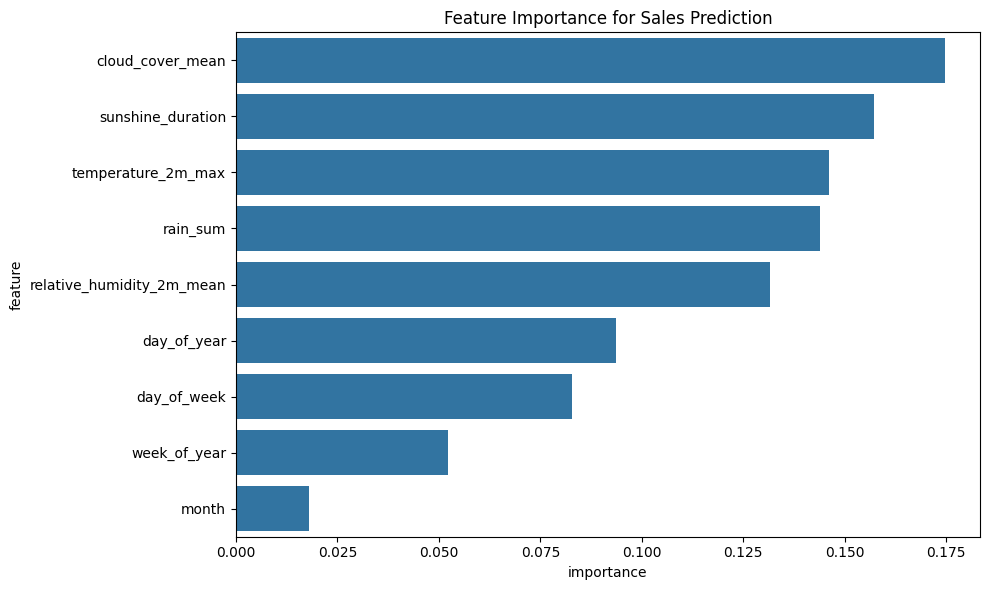

In [19]:
# --- 5. Feature Importance ---
print("\n--- 5. Feature Importance ---")
feature_importances = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

print(feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance for Sales Prediction')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()


--- 6. Membuat Visualisasi Actual vs. Predicted ---


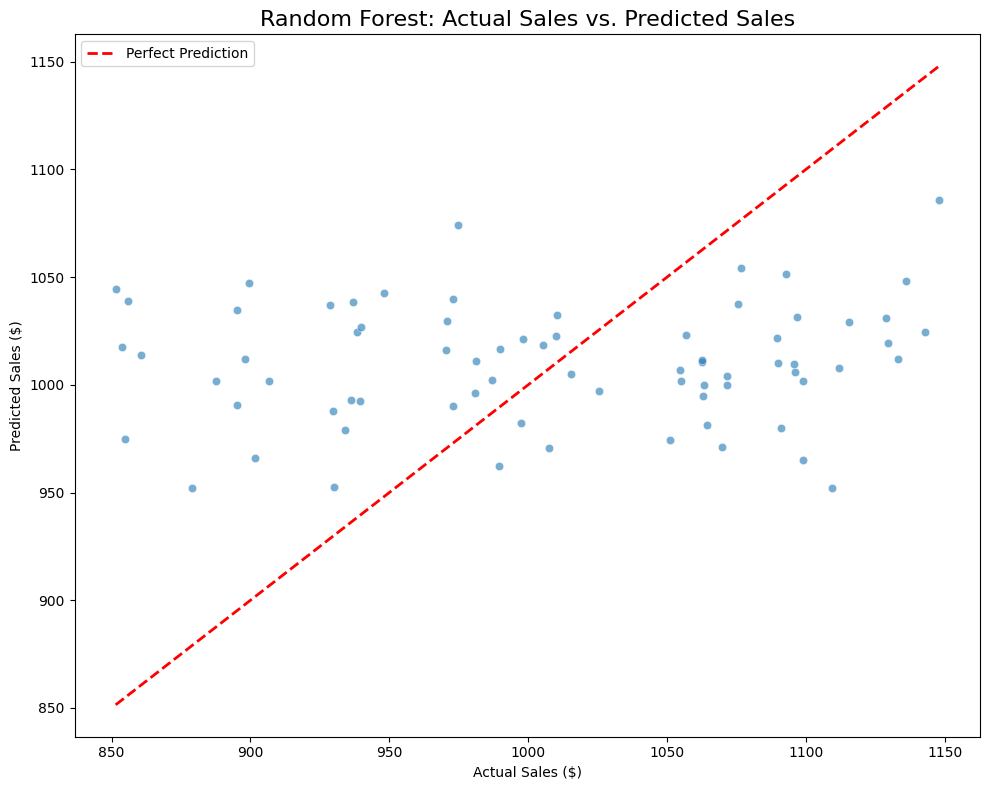


✅ Visualisasi Actual vs. Predicted berhasil dibuat dan disimpan sebagai 'actual_vs_predicted.png'


In [30]:
# --- 6. Visualisasi Actual vs. Predicted Sales ---
print("\n--- 6. Membuat Visualisasi Actual vs. Predicted ---")

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Perfect Prediction')
plt.title('Random Forest: Actual Sales vs. Predicted Sales', fontsize=16)
plt.xlabel('Actual Sales ($)')
plt.ylabel('Predicted Sales ($)')
plt.legend()
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

print("\n✅ Visualisasi Actual vs. Predicted berhasil dibuat dan disimpan sebagai 'actual_vs_predicted.png'")

#Linear Regression

In [32]:
print("--- 1. Memuat Data ---")
file_path = 'data_gabungan_penjualan_cuaca.csv'
df = pd.read_csv(file_path)

# Mengisi nilai kosong (jika ada)
df.fillna(df.mean(numeric_only=True), inplace=True)
print("✅ Data berhasil dimuat.")

--- 1. Memuat Data ---
✅ Data berhasil dimuat.


In [33]:
# --- 2. Feature Engineering ---
print("\n--- 2. Feature Engineering ---")
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['week_of_year'] = df['date'].dt.isocalendar().week
df['day_of_year'] = df['date'].dt.dayofyear
print("✅ Fitur berbasis waktu berhasil dibuat.")

# Memilih fitur yang sama seperti sebelumnya
features = [
    'temperature_2m_max', 'rain_sum', 'sunshine_duration',
    'relative_humidity_2m_mean', 'cloud_cover_mean',
    'day_of_week', 'month', 'week_of_year', 'day_of_year'
]
target = 'Sales'

X = df[features]
y = df[target]


--- 2. Feature Engineering ---
✅ Fitur berbasis waktu berhasil dibuat.


In [34]:
# --- 3. Model Training ---
print("\n--- 3. Model Training (Linear Regression) ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print("✅ Model Linear Regression berhasil dilatih.")



--- 3. Model Training (Linear Regression) ---
✅ Model Linear Regression berhasil dilatih.


In [35]:
# --- 4. Model Evaluation ---
print("\n--- 4. Hasil Evaluasi Linear Regression ---")
predictions = lr_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")


--- 4. Hasil Evaluasi Linear Regression ---
R-squared (R²): -0.0405
Mean Absolute Error (MAE): $75.50


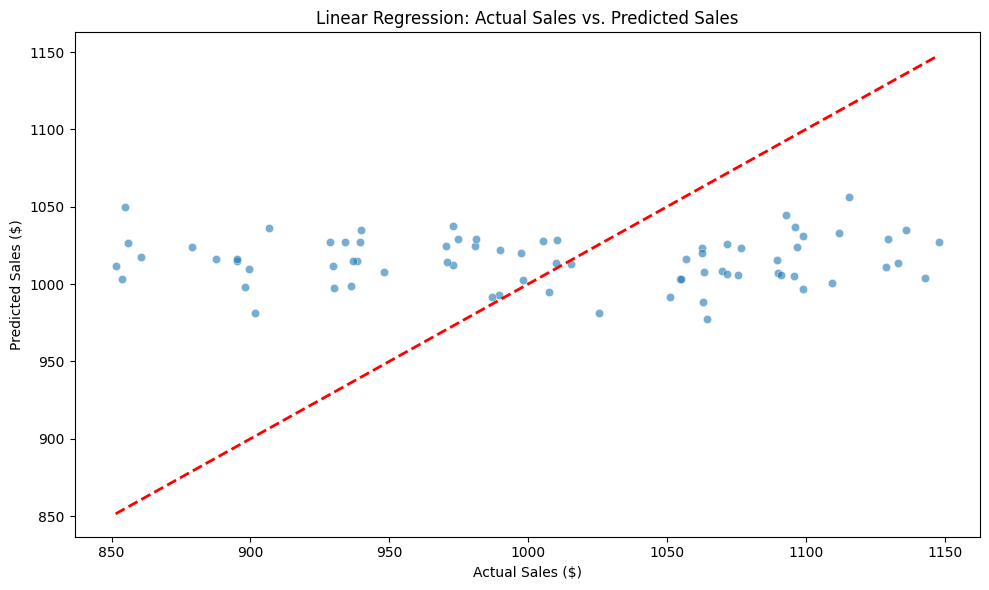

In [36]:
# --- 5. Visualisasi Hasil Prediksi ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2) # Garis ideal
plt.title('Linear Regression: Actual Sales vs. Predicted Sales')
plt.xlabel('Actual Sales ($)')
plt.ylabel('Predicted Sales ($)')
plt.tight_layout()
plt.savefig('linear_regression_results.png')
plt.show()